In [50]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [51]:
 data_dir="/content/drive/MyDrive/Flowers-Dataset/flowers"

In [52]:
print(os.listdir("/content/drive/MyDrive/Flowers-Dataset/flowers"))

['sunflower', 'daisy', 'dandelion', 'rose', 'tulip']


Image Augumentation

In [53]:
data_aug = Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [54]:
batch_size = 16
img_height = 180
img_width = 180

In [55]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [57]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [58]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


In [59]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardization of data

In [60]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [61]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99869287


Create The Model

In [62]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile The Model

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
216/216 [==============================] - 267s 1s/step - loss: 1.2929 - accuracy: 0.4418 - val_loss: 1.1421 - val_accuracy: 0.5330
Epoch 2/10
216/216 [==============================] - 136s 629ms/step - loss: 1.0011 - accuracy: 0.6091 - val_loss: 0.9813 - val_accuracy: 0.6083
Epoch 3/10
216/216 [==============================] - 130s 601ms/step - loss: 0.8602 - accuracy: 0.6668 - val_loss: 0.8838 - val_accuracy: 0.6547
Epoch 4/10
216/216 [==============================] - 128s 590ms/step - loss: 0.7487 - accuracy: 0.7131 - val_loss: 0.8505 - val_accuracy: 0.6698
Epoch 5/10
216/216 [==============================] - 133s 616ms/step - loss: 0.5949 - accuracy: 0.7739 - val_loss: 0.8759 - val_accuracy: 0.6895
Epoch 6/10
216/216 [==============================] - 131s 606ms/step - loss: 0.4240 - accuracy: 0.8480 - val_loss: 1.0287 - val_accuracy: 0.6802
Epoch 7/10
216/216 [==============================] - 131s 606ms/step - loss: 0.2849 - accuracy: 0.8987 - val_loss: 1.2919 - va

Training results before using CNN

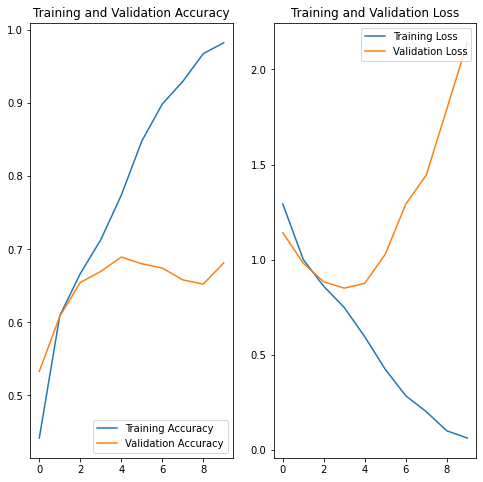

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

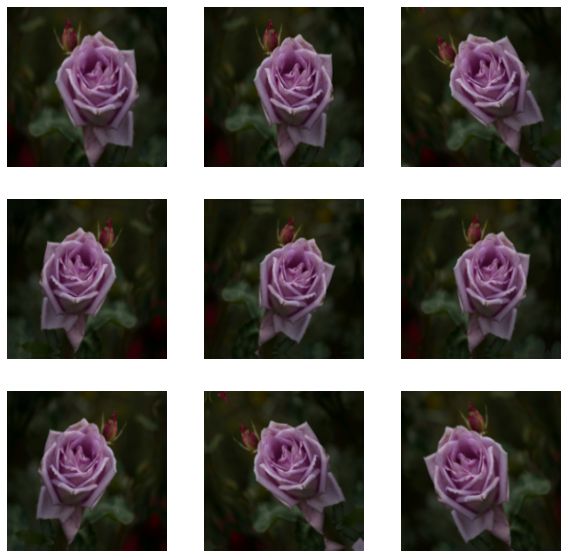

In [70]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [71]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [72]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Compile the model using CNN

In [73]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Fit the model using CNN

In [75]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
216/216 [==============================] - 147s 681ms/step - loss: 0.4412 - accuracy: 0.8338 - val_loss: 1.0078 - val_accuracy: 0.6976
Epoch 2/15
216/216 [==============================] - 127s 587ms/step - loss: 0.4412 - accuracy: 0.8338 - val_loss: 0.7737 - val_accuracy: 0.7590
Epoch 3/15
216/216 [==============================] - 127s 587ms/step - loss: 0.4133 - accuracy: 0.8474 - val_loss: 0.7360 - val_accuracy: 0.7601
Epoch 4/15
216/216 [==============================] - 126s 585ms/step - loss: 0.3784 - accuracy: 0.8518 - val_loss: 0.8077 - val_accuracy: 0.7323
Epoch 5/15
216/216 [==============================] - 126s 583ms/step - loss: 0.3858 - accuracy: 0.8564 - val_loss: 0.8681 - val_accuracy: 0.7486
Epoch 6/15
216/216 [==============================] - 125s 580ms/step - loss: 0.3588 - accuracy: 0.8677 - val_loss: 0.8312 - val_accuracy: 0.7462
Epoch 7/15
216/216 [==============================] - 125s 581ms/step - loss: 0.3821 - accuracy: 0.8555 - val_loss: 0.8144 -

Training results after using CNN

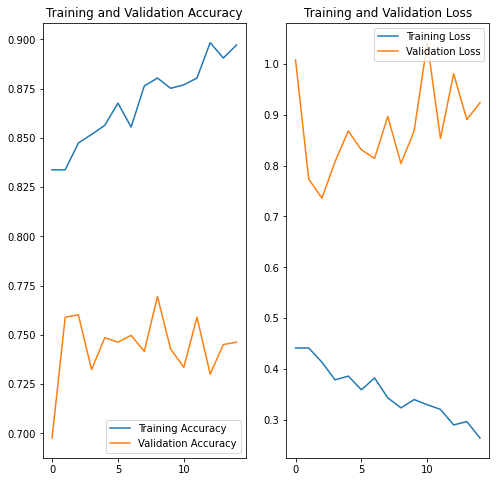

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save The Model

In [77]:
model.save("./flowermodel.h5")

In [78]:
model.load_weights('./flowermodel.h5')

Test The Model

In [88]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

Saving 5547758_eea9edfd54_n.jpg to 5547758_eea9edfd54_n.jpg


In [95]:
database = ImageFolder(data_dir, transform=transformer)

Predicted Output: daisy


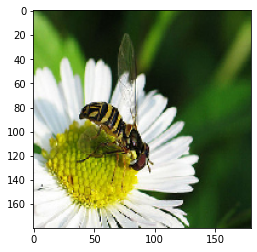

In [96]:
for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(180, 180))
  
  x=image.img_to_array(img)
  test_img=np.expand_dims(x, axis=0)
  
  
  result = model.predict(test_img)
  pred = np.argmax(result) # get the index of max value
  plt.imshow(img)
  print("Predicted Output:",database.classes[pred])